In [1]:
import pandas as pd
import numpy as np
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn import tree
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
import warnings
import xgboost
import lightgbm as lgb
import seaborn as sns
import datetime

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
warnings.filterwarnings("ignore")

## Import CSV

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Cleaning

In [4]:
obj_cols = train.select_dtypes(include='object').columns.tolist()
num_cols = train.select_dtypes(include=['int64','float64']).columns.tolist()
num_cols.remove('SalePrice')
num_cols.remove('Id')

In [5]:
def impute_object(df, obj_cols):
    df_copy = df.copy()
    # impute object null to Na/No/None if stated in description
    df_copy['Alley'].fillna('None', inplace = True)
    df_copy['MasVnrType'].fillna('None', inplace = True)
    df_copy['BsmtQual'].fillna('None', inplace = True)
    df_copy['BsmtCond'].fillna('NA', inplace = True)
    df_copy['BsmtExposure'].fillna('No', inplace = True)
    df_copy['BsmtFinType1'].fillna('NA', inplace = True)
    df_copy['BsmtFinType2'].fillna('NA', inplace = True)
    df_copy['FireplaceQu'].fillna('NA', inplace = True)
    df_copy['GarageType'].fillna('NA', inplace = True)
    df_copy['GarageFinish'].fillna('NA', inplace = True)
    df_copy['GarageQual'].fillna('NA', inplace = True)
    df_copy['GarageCond'].fillna('NA', inplace = True)
    df_copy['PoolQC'].fillna('NA', inplace = True)
    df_copy['Fence'].fillna('NA', inplace = True)
    df_copy['MiscFeature'].fillna('NA', inplace = True)

    # impute object null to mode value for not stated in description
    object_imputer = SimpleImputer(strategy='most_frequent', fill_value='missing_value')
    for col in obj_cols:
        df_copy[col] = object_imputer.fit_transform(df_copy[col].values.reshape(-1,1))
    return df_copy

In [6]:
train = impute_object(train, obj_cols)
test = impute_object(test, obj_cols)

In [7]:
def impute_numeric(df,num_cols):
    df_copy = df.copy()
    # impute numeric value to median
    imputer = Imputer(strategy = 'median')
    for col in num_cols:
        df_copy[col] = imputer.fit_transform(df_copy[col].values.reshape(-1,1))
    return df_copy

In [8]:
train = impute_numeric(train, num_cols)
test = impute_numeric(test, num_cols)

## EDA

### Basement Features

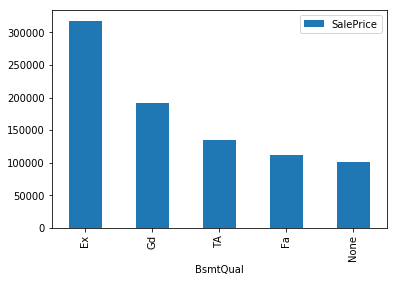

In [9]:
##Basement Quality affect SalePrice linearly
train[['BsmtQual','SalePrice']].groupby('BsmtQual').median().sort_values('SalePrice', ascending=False).plot.bar()

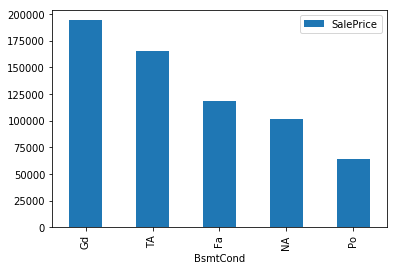

In [10]:
##People prefer no basement rather than poor quality basement
train[['BsmtCond','SalePrice']].groupby('BsmtCond').median().sort_values('SalePrice', ascending=False).plot.bar()

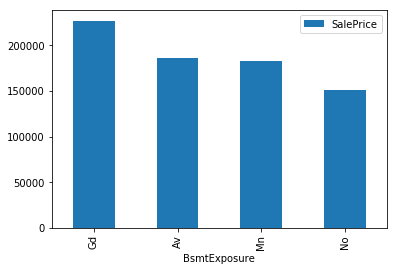

In [11]:
train[['BsmtExposure','SalePrice']].groupby('BsmtExposure').median().sort_values('SalePrice', ascending=False).plot.bar()

In [12]:
agg_bsmt = train[['BsmtQual','BsmtCond','BsmtExposure','SalePrice']]\
            .groupby(['BsmtCond','BsmtQual','BsmtExposure']).median()\
            .sort_values('SalePrice', ascending=False)

In [13]:
agg_bsmt['rank'] = agg_bsmt['SalePrice'].rank(ascending = True) 

In [14]:
clf = tree.DecisionTreeClassifier()

In [15]:
agg_bsmt['BsmtQual'] = agg_bsmt.index.get_level_values('BsmtQual')
agg_bsmt['BsmtCond'] = agg_bsmt.index.get_level_values('BsmtCond')
agg_bsmt['BsmtExposure'] = agg_bsmt.index.get_level_values('BsmtExposure')

In [16]:
one_hot_bsmt = pd.get_dummies(agg_bsmt[['BsmtQual','BsmtCond','BsmtExposure']])
test_bsmt = pd.get_dummies(test[['BsmtQual','BsmtCond','BsmtExposure']]) 

In [17]:
bsmt_cols = [one_hot_bsmt.columns.values.tolist()[i] for i in [one_hot_bsmt.columns.values.tolist().index(x) 
                                          for x in test_bsmt.columns.values.tolist()]]

In [18]:
clf = clf.fit(one_hot_bsmt[bsmt_cols], agg_bsmt['rank'])

### Garage Features

In [19]:
garage_col = train.columns.values.tolist() 
garage_col = [s for s in garage_col if any(xs in s for xs in ['Garage','SalePrice'])]

In [20]:
garage_df = train[garage_col].copy()

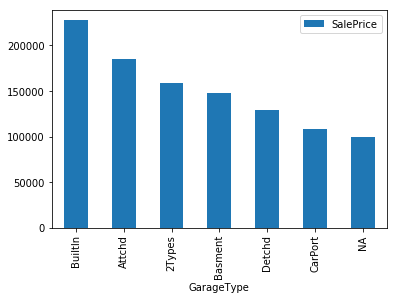

In [21]:
garage_df[['GarageType','SalePrice']].groupby('GarageType').median().sort_values('SalePrice', ascending=False).plot.bar()

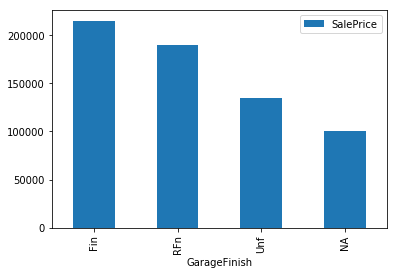

In [22]:
garage_df[['GarageFinish','SalePrice']].groupby('GarageFinish').median().sort_values('SalePrice', ascending=False).plot.bar()

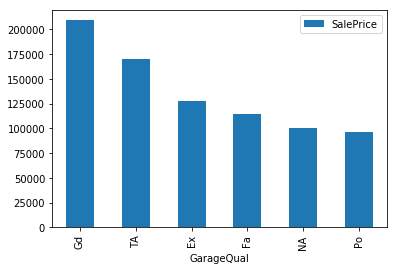

In [23]:
garage_df[['GarageQual','SalePrice']].groupby('GarageQual').median().sort_values('SalePrice', ascending=False).plot.bar()

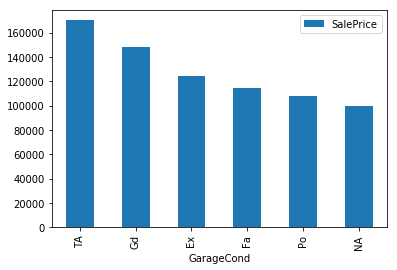

In [24]:
garage_df[['GarageCond','SalePrice']].groupby('GarageCond').median().sort_values('SalePrice', ascending=False).plot.bar()

In [25]:
agg_garage = garage_df[['GarageType','GarageFinish','GarageQual','GarageCond','SalePrice']]\
            .groupby(['GarageType','GarageFinish','GarageQual','GarageCond']).median()\
            .sort_values('SalePrice', ascending=False)

In [26]:
agg_garage['rank'] = agg_garage['SalePrice'].rank(ascending = True) 
agg_garage['rank'] = agg_garage['rank'].astype(int)

In [27]:
clf_garage = tree.DecisionTreeClassifier()
agg_garage['GarageType'] = agg_garage.index.get_level_values('GarageType')
agg_garage['GarageFinish'] = agg_garage.index.get_level_values('GarageFinish')
agg_garage['GarageQual'] = agg_garage.index.get_level_values('GarageQual')
agg_garage['GarageCond'] = agg_garage.index.get_level_values('GarageCond')

one_hot_garage = pd.get_dummies(agg_garage[['GarageType','GarageFinish','GarageQual','GarageCond']])
test_garage = pd.get_dummies(test[['GarageType','GarageFinish','GarageQual','GarageCond']]) 

In [28]:
garage_cols = [one_hot_garage.columns.values.tolist()[i] for i in [one_hot_garage.columns.values.tolist().index(x) 
                                          for x in test_garage.columns.values.tolist()]]

In [29]:
clf_garage = clf_garage.fit(one_hot_garage[garage_cols], agg_garage['rank'])

### Exterior Features

In [30]:
exter_col = train.columns.values.tolist() 
exter_col = [s for s in exter_col if any(xs in s for xs in ['Exter','SalePrice'])]

In [31]:
exter_df = train[exter_col].copy()

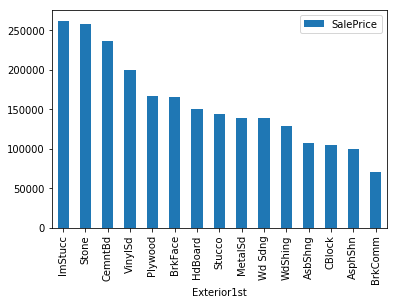

In [32]:
exter_df[['Exterior1st','SalePrice']].groupby('Exterior1st').median().sort_values('SalePrice', ascending=False).plot.bar()

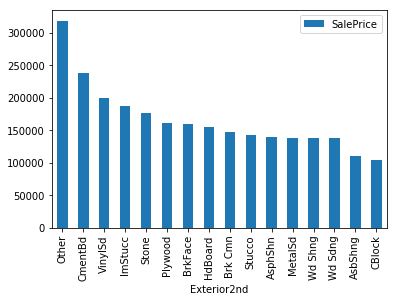

In [33]:
exter_df[['Exterior2nd','SalePrice']].groupby('Exterior2nd').median().sort_values('SalePrice', ascending=False).plot.bar()

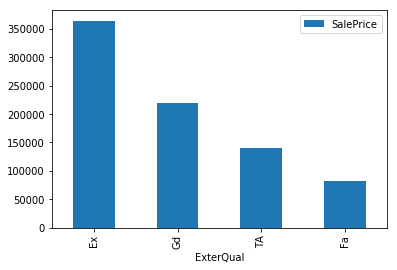

In [34]:
exter_df[['ExterQual','SalePrice']].groupby('ExterQual').median().sort_values('SalePrice', ascending=False).plot.bar()

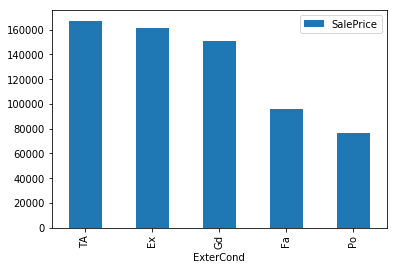

In [35]:
exter_df[['ExterCond','SalePrice']].groupby('ExterCond').median().sort_values('SalePrice', ascending=False).plot.bar()

In [36]:
agg_exter = exter_df.groupby(['Exterior1st','Exterior2nd','ExterQual','ExterCond']).median()\
            .sort_values('SalePrice', ascending=False)

In [37]:
agg_exter['rank'] = agg_exter['SalePrice'].rank(ascending = True) 
agg_exter['rank'] = agg_exter['rank'].astype(int)

In [38]:
clf_exter = tree.DecisionTreeClassifier()
agg_exter['Exterior1st'] = agg_exter.index.get_level_values('Exterior1st')
agg_exter['Exterior2nd'] = agg_exter.index.get_level_values('Exterior2nd')
agg_exter['ExterQual'] = agg_exter.index.get_level_values('ExterQual')
agg_exter['ExterCond'] = agg_exter.index.get_level_values('ExterCond')

one_hot_exter = pd.get_dummies(agg_exter[['Exterior1st','Exterior2nd','ExterQual','ExterCond']])
test_exter = pd.get_dummies(test[['Exterior1st','Exterior2nd','ExterQual','ExterCond']])

In [39]:
exter_cols = [one_hot_exter.columns.values.tolist()[i] for i in [one_hot_exter.columns.values.tolist().index(x) 
                                          for x in test_exter.columns.values.tolist()]]

In [40]:
clf_exter = clf_exter.fit(one_hot_exter[exter_cols], agg_exter['rank'])

## Label Encode

In [41]:
def encode_by_rank(df, clf_model, column):
    df_dummies = pd.get_dummies(df)
    df_dummies['rank'] = clf_model.predict(df_dummies[column])
    return df_dummies['rank']

In [42]:
train['rank_bsmt'] = encode_by_rank(train, clf, bsmt_cols)
train['rank_garage'] = encode_by_rank(train, clf_garage, garage_cols)
train['rank_exter'] = encode_by_rank(train, clf_exter, exter_cols)

In [43]:
test['rank_bsmt'] = encode_by_rank(test, clf, bsmt_cols)
test['rank_garage'] = encode_by_rank(test, clf_garage, garage_cols)
test['rank_exter'] = encode_by_rank(test, clf_exter, exter_cols)

## Feature Scaling

### Skewness Check

In [44]:
skew_cols = train[num_cols].skew().sort_values(ascending = False)
skew_cols = skew_cols[abs(skew_cols) > 2].index.values.tolist()

### Log Transform Skew Data (skewness > 2)

In [45]:
def log_transform(df, column):
    return np.log(df[column] + 1)

In [46]:
train_processed = train.copy()
test_processed = test.copy()

In [47]:
for skew_col in skew_cols:
    train_processed[skew_col] = log_transform(train_processed, skew_col)
    test_processed[skew_col] = log_transform(test_processed, skew_col)

## Feature Selection

In [48]:
train_processed = pd.get_dummies(train_processed)
test_processed = pd.get_dummies(test_processed)

In [49]:
correlation = train_processed.corr()['SalePrice'].sort_values()

## Label and Feature Separation

In [50]:
label = train['SalePrice']

In [51]:
feat_cols_train = train_processed.columns.values.tolist()
feat_cols_test = test_processed.columns.values.tolist()

In [52]:
feat_cols = [feat_cols_train[i] for i in [feat_cols_train.index(x) for x in feat_cols_test]]
feat_cols.remove('Id')

In [53]:
features = train_processed[feat_cols]

In [54]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)

In [55]:
gbm = lgb.LGBMRegressor(boosting_type='gbdt', 
                        num_leaves=31, 
                        max_depth=-1, 
                        learning_rate=0.01, 
                        n_estimators=1000, 
                        max_bin=255, 
                        subsample_for_bin=50000, 
                        objective='regression', 
                        min_split_gain=0, 
                        min_child_weight=3,
                        min_child_samples=10, 
                        subsample=1, 
                        subsample_freq=1, 
                        colsample_bytree=1, 
                        reg_alpha=0.1, 
                        reg_lambda=0, 
                        seed=17,
                        silent=False, 
                        nthread=-1)

In [56]:
gbm.fit(X_train, y_train, 
            eval_metric='rmse',
            eval_set=[(X_test, y_test)],
            verbose = True)

[1]	valid_0's rmse: 86948.6	valid_0's l2: 7.56006e+09
[2]	valid_0's rmse: 86296.4	valid_0's l2: 7.44707e+09
[3]	valid_0's rmse: 85640.9	valid_0's l2: 7.33436e+09
[4]	valid_0's rmse: 85003.2	valid_0's l2: 7.22555e+09
[5]	valid_0's rmse: 84365.1	valid_0's l2: 7.11748e+09
[6]	valid_0's rmse: 83750.3	valid_0's l2: 7.01411e+09
[7]	valid_0's rmse: 83135.5	valid_0's l2: 6.9115e+09
[8]	valid_0's rmse: 82517.5	valid_0's l2: 6.80915e+09
[9]	valid_0's rmse: 81906.5	valid_0's l2: 6.70867e+09
[10]	valid_0's rmse: 81318	valid_0's l2: 6.61261e+09
[11]	valid_0's rmse: 80724	valid_0's l2: 6.51636e+09
[12]	valid_0's rmse: 80132.1	valid_0's l2: 6.42115e+09
[13]	valid_0's rmse: 79543.7	valid_0's l2: 6.3272e+09
[14]	valid_0's rmse: 78959.4	valid_0's l2: 6.23459e+09
[15]	valid_0's rmse: 78377.1	valid_0's l2: 6.14298e+09
[16]	valid_0's rmse: 77828.2	valid_0's l2: 6.05723e+09
[17]	valid_0's rmse: 77286.7	valid_0's l2: 5.97324e+09
[18]	valid_0's rmse: 76728.1	valid_0's l2: 5.88721e+09
[19]	valid_0's rmse: 7618

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1,
       importance_type='split', learning_rate=0.01, max_bin=255,
       max_depth=-1, min_child_samples=10, min_child_weight=3,
       min_split_gain=0, n_estimators=1000, n_jobs=-1, nthread=-1,
       num_leaves=31, objective='regression', random_state=None,
       reg_alpha=0.1, reg_lambda=0, seed=17, silent=False, subsample=1,
       subsample_for_bin=50000, subsample_freq=1)

In [57]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,X_train.columns)), columns=['Value','Feature'])
# take only top 80 % features
feature_imp['cum_pct'] = feature_imp['Value'].cumsum()/feature_imp['Value'].sum()

In [58]:
top_feats = feature_imp.loc[feature_imp['cum_pct'] >= 0.2]['Feature'].values.tolist()

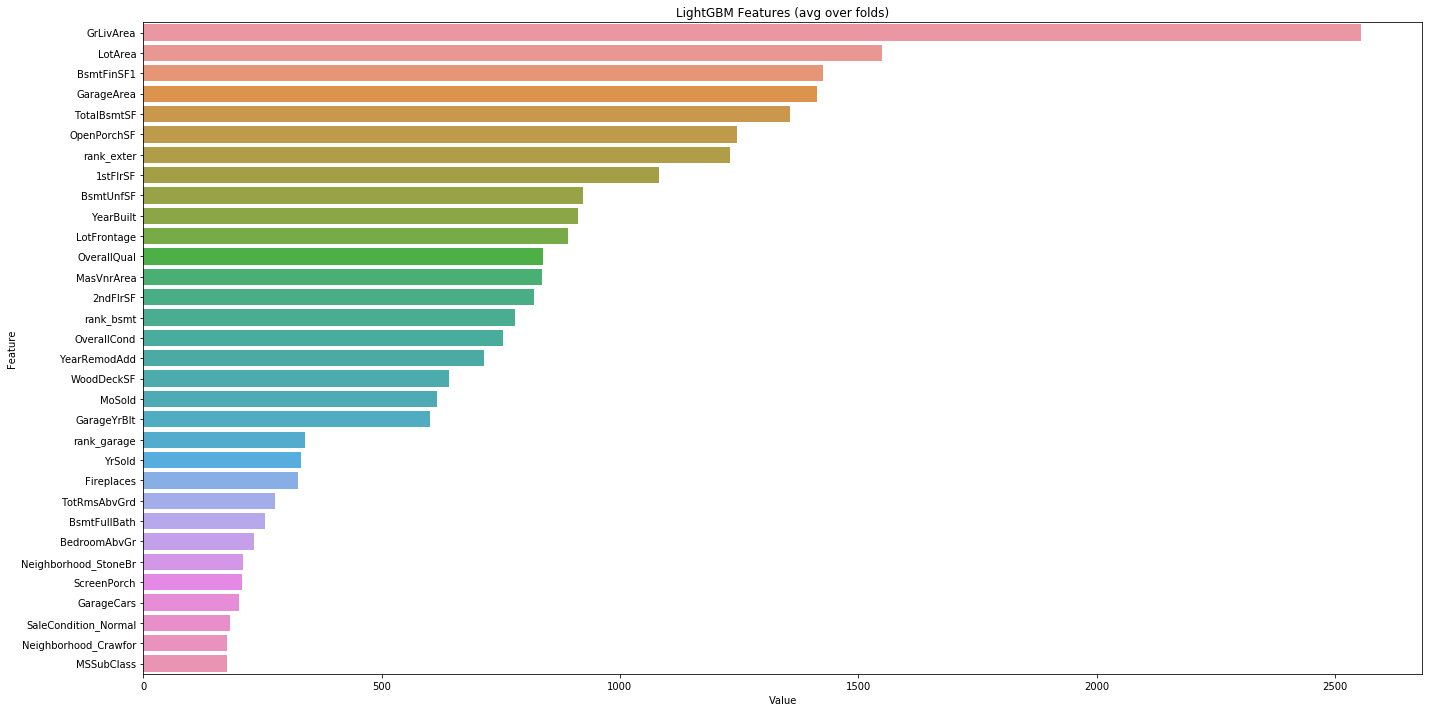

In [59]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.loc[feature_imp['cum_pct'] >= 0.2].sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(features[top_feats], label, test_size=0.2, random_state=42)

## Linear Regression

In [61]:
linreg = LinearRegression()

In [62]:
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [63]:
price_prediction = abs(linreg.predict(X_test))

## Random Forest Regression

In [64]:
forest_reg = RandomForestRegressor()

In [65]:
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
f_price_prediction = forest_reg.predict(X_test)

## XGBoost

In [67]:
xgb = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.01,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [68]:
xgb.fit(X_train, y_train)

[07:26:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.6, verbosity=1)

In [69]:
xgb_predict = xgb.predict(X_test)

## Performance Benchmarking

In [70]:
def cross_validate(model, features, label, n_cv):
    scores = cross_val_score(model, features, label,
                             scoring="neg_mean_squared_error", cv=n_cv)
    rmse_scores = np.sqrt(-scores)
    
    return rmse_scores

In [71]:
models = {'linear' : linreg, 'random forest': forest_reg, 'xgboost': xgb}

In [72]:
def model_benchmark(models, X_test, y_test, n_cv):
    performance_benchmark = pd.DataFrame(columns=['model','rmsle'])
    for model in models:
        temp_model = [model]*n_cv
        temp_performance = cross_validate(models[model], X_test, y_test, n_cv)
        temp_df = pd.DataFrame({'model': temp_model, 'rmsle': temp_performance})
        performance_benchmark = pd.merge(performance_benchmark, temp_df, how = 'outer')
    sns.boxplot(x="model", y="rmsle", data=performance_benchmark)
    plt.title('Performance Benchmark')

[07:26:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:46] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:26:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:27:08] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

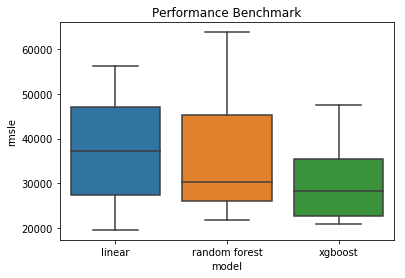

In [73]:
model_benchmark(models, X_test, y_test, 10)

## Fine Tuning

In [74]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.5, 1, 1.5, 2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'reg_alpha': [0, 0.25, 0.5, 0.75],
        'reg_lambda': [0.45, 0.75 , 1]
        }

In [75]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

In [76]:
random_search = RandomizedSearchCV(xgb, 
                                   param_distributions=params, 
                                   n_iter=param_comb, 
                                   scoring='neg_mean_squared_error', 
                                   n_jobs=1, 
                                   cv=skf.split(features[top_feats], label), 
                                   verbose=3, 
                                   random_state=1001 )

In [77]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [78]:
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(features[top_feats], label)
timer(start_time) # timing ends here for "start_time" variable

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6 
[07:27:14] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6, score=-1940015862.5273104, total=   8.0s
[CV] subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6 
[07:27:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.2s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6, score=-382293955.44895065, total=  13.5s
[CV] subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6 
[07:27:36] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.2s remaining:    0.0s


[CV]  subsample=0.8, reg_lambda=0.45, reg_alpha=0, min_child_weight=5, max_depth=3, gamma=2, colsample_bytree=0.6, score=-534161211.04753876, total=  12.9s
[CV] subsample=1.0, reg_lambda=1, reg_alpha=0.25, min_child_weight=1, max_depth=4, gamma=0.5, colsample_bytree=1.0 
[07:27:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=1.0, reg_lambda=1, reg_alpha=0.25, min_child_weight=1, max_depth=4, gamma=0.5, colsample_bytree=1.0, score=-1965022833.1923244, total=  13.0s
[CV] subsample=1.0, reg_lambda=1, reg_alpha=0.25, min_child_weight=1, max_depth=4, gamma=0.5, colsample_bytree=1.0 
[07:28:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  subsample=1.0, reg_lambda=1, reg_alpha=0.25, min_child_weight=1, max_depth=4, gamma=0.5, colsample_bytree=1.0, score=-439115439.6948603, total=  22.0s
[CV] subsample=1.0, reg_lambda=1, reg_alpha=0.25, min_child_weigh

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.5min finished



 Time taken: 0 hours 3 minutes and 48.95 seconds.


In [79]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

results = pd.DataFrame(random_search.cv_results_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4, gamma=0,
       importance_type='gain', learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=5, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=1, scale_pos_weight=1, seed=42,
       silent=None, subsample=0.8, verbosity=1)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
-2605764576.0428395

 Best hyperparameters:
{'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.75, 'min_child_weight': 5, 'max_depth': 5, 'gamma': 0, 'colsample_bytree': 0.4}


In [80]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_min_child_weight,param_max_depth,param_gamma,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,11.322579,2.558211,0.167667,0.086751,0.8,0.45,0,5,3,2,...,-3.822940e+08,-5.341612e+08,-1.305660e+09,7.318360e+08,2,-1.039820e+06,-1.192267e+07,-1.162825e+07,-8.196913e+06,5.062256e+06
1,18.237847,4.090675,0.281827,0.144410,1,1,0.25,1,4,0.5,...,-4.391154e+08,-4.585363e+08,-1.313236e+09,7.502445e+08,3,-1.773978e+04,-1.097234e+06,-8.220232e+05,-6.456658e+05,4.580055e+05
2,12.479524,2.806852,0.447403,0.172553,0.8,1,0.75,5,5,0,...,-3.597504e+08,-4.403362e+08,-1.302882e+09,7.815935e+08,1,-1.836942e+03,-1.209683e+05,-1.289861e+05,-8.393044e+04,5.814108e+04
3,12.104792,2.669150,0.467037,0.191146,1,0.45,0.25,1,5,0,...,-3.941513e+08,-4.283882e+08,-1.368278e+09,8.301473e+08,5,-6.340242e+01,-3.990154e+04,-5.148900e+04,-3.048465e+04,2.202508e+04
4,11.331043,2.569042,0.173500,0.089949,0.8,1,0.25,5,3,0.5,...,-3.852090e+08,-5.301128e+08,-1.318987e+09,7.440095e+08,4,-1.158902e+06,-1.315120e+07,-1.272036e+07,-9.010152e+06,5.554458e+06


## Export Model

In [81]:
joblib.dump(clf, 'bsmt_clf.pkl')
joblib.dump(linreg, 'lin_reg_1.pkl')
joblib.dump(forest_reg, 'forest_reg_1.pkl')
joblib.dump(xgb, 'xgb_1.pkl')
joblib.dump(random_search.best_estimator_, 'xgb_best.pkl')

['xgb_best.pkl']

## Generate Ouput CSV for Kaggle

In [97]:
def predict_export_csv(model, feature, index, file_name):
    temp_output = model.predict(feature)
    temp_output_df = pd.DataFrame({'Id': index, 'SalePrice': temp_output })
    temp_output_df.to_csv('{}.csv'.format(file_name), sep=',', encoding='utf-8', index=False)

In [99]:
predict_export_csv(random_search, test_processed[top_feats], test['Id'], 'house_prediction')